In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../train.csv')

In [4]:
label_names = ['None', 'Lead', 'Position', 'Evidence', 'Claim',
               'Concluding Statement', 'Counterclaim', 'Rebuttal']

In [3]:
per_id_entity_counts = data.groupby('id').apply(lambda x: x.discourse_type.value_counts()).unstack().fillna(0)

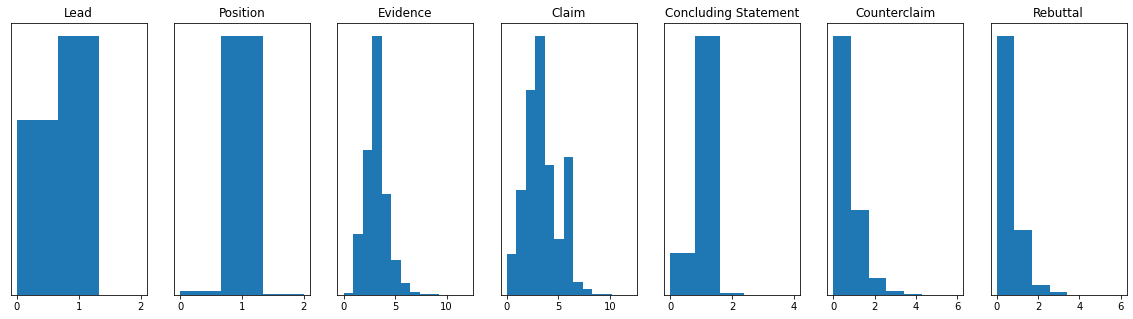

In [7]:
entity_types = per_id_entity_counts.columns
fig, axs = plt.subplots(1, len(entity_types), figsize=(20, 5))
for ix in range(len(label_names) - 1):
    axs[ix].hist(per_id_entity_counts[label_names[ix + 1]], int(per_id_entity_counts[label_names[ix + 1]].max() + 1))
    axs[ix].set_title(label_names[ix + 1])
    axs[ix].set_yticks([])

In [8]:
def num_words_in_target(x):
    chunks = x.split()
    return int(chunks[-1]) - int(chunks[0]) + 1

In [9]:
data['num_target_words'] = data.predictionstring.map(num_words_in_target)

In [10]:
num_words_per_entity = data.groupby('discourse_type').apply(lambda x: x.num_target_words.value_counts()).unstack().fillna(0)

In [11]:
more_than_299_words = num_words_per_entity[num_words_per_entity.columns[num_words_per_entity.columns >= 300]].values.sum(-1)

In [12]:
num_words_per_entity = num_words_per_entity[num_words_per_entity.columns[num_words_per_entity.columns < 300]]
num_words_per_entity[300] = more_than_299_words

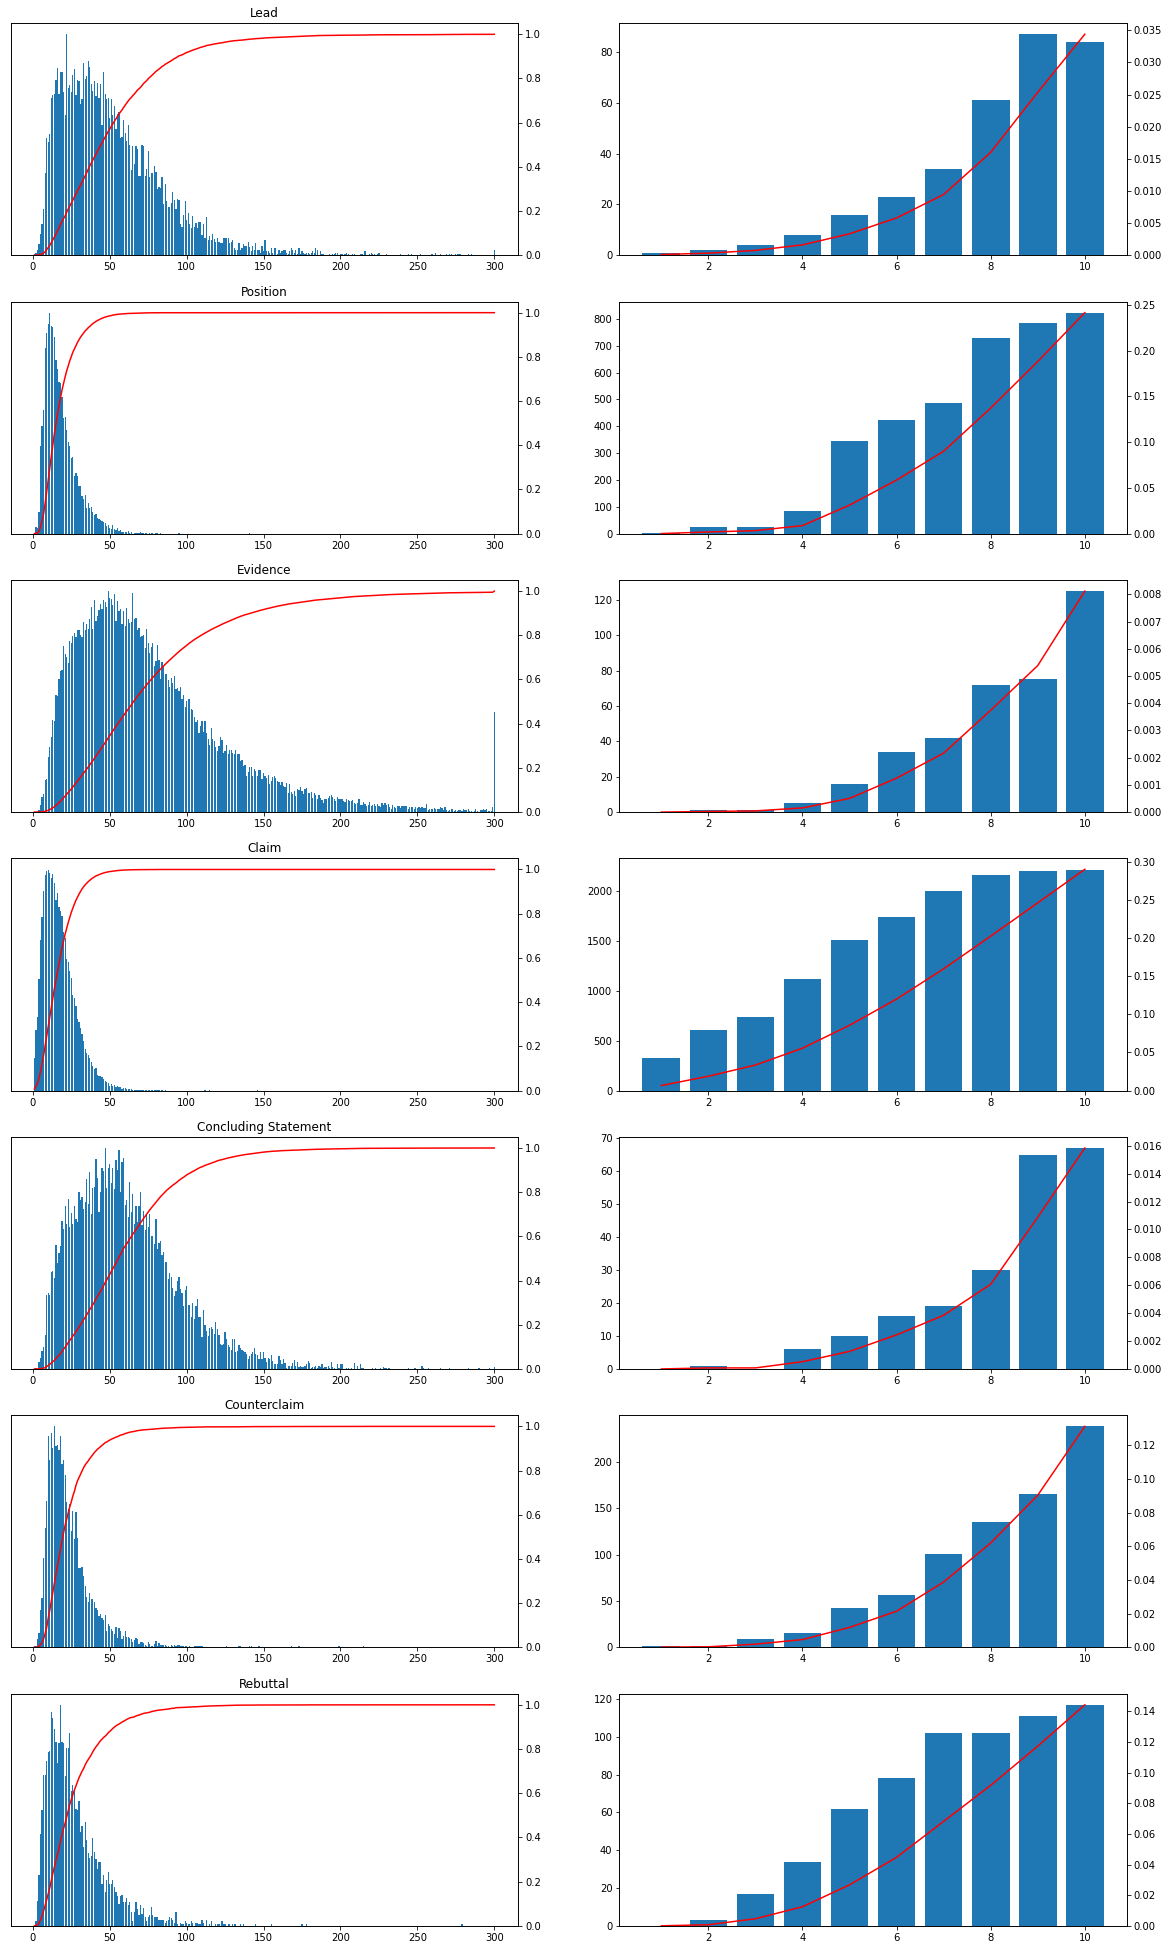

In [14]:
entity_types = per_id_entity_counts.columns
fig, axs = plt.subplots(len(entity_types), 2, figsize=(20, 5 * len(entity_types)))
for ix in range(len(label_names) - 1):
    word_counts = num_words_per_entity.loc[label_names[ix + 1]]
    total_ents = word_counts.sum()
    cumulative = word_counts.cumsum() / total_ents
    axs[ix, 0].bar(range(1, 301), word_counts)
    extra_ax = axs[ix, 0].twinx()
    extra_ax.plot(cumulative, c='r')
    extra_ax.set_ylim(bottom=0)
    axs[ix, 1].bar(range(1, 11), word_counts[:10])
    extra_ax = axs[ix, 1].twinx()
    extra_ax.plot(cumulative[:10], c='r')
    extra_ax.set_ylim(bottom=0)
    axs[ix, 0].set_title(label_names[ix + 1])
for ax in axs[:, 0]:
    ax.set_yticks([])

In [16]:
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
with open('../data_splits.pickle', 'rb') as f:
    data_splits = pickle.load(f)
val_bounds = np.cumsum([0] + [len(data_splits[0][250]['normed'][fold_ix]) for fold_ix in range(5)])

In [18]:
def extract_entities(ps, n):
    cat_ps = ps.argmax(-1)
    all_entities = {}
    current_cat = None
    current_start = None
    for ix in range(1, n - 1):
        if cat_ps[ix] % 2 == 1:
            if current_cat is not None:
                if current_cat not in all_entities:
                    all_entities[current_cat] = []
                all_entities[current_cat].append((current_start, ix - 1))
            current_cat = (cat_ps[ix] + 1) // 2
            current_start = ix
        elif cat_ps[ix] == 0:
            if current_cat is not None:
                if current_cat not in all_entities:
                    all_entities[current_cat] = []
                all_entities[current_cat].append((current_start, ix - 1))
            current_cat = None
    if current_cat is not None:
        if current_cat not in all_entities:
            all_entities[current_cat] = []
        all_entities[current_cat].append((current_start, ix))
    
    for cat_ix, min_len in zip(range(1, 8), (1 , 2, 5, 1, 4, 3, 2)):
        if cat_ix in all_entities:
            all_entities[cat_ix] = [x for x in all_entities[cat_ix] if x[1] - x[0] + 1 >= min_len]
    return all_entities

def process_sample(raw_ps, index_map, bounds, gt_spans, num_tokens, match_stats, min_len=0):
    
    matched_ps = {cat_ix: [] for cat_ix in range(1, 8)}
    mismatched_ps = {cat_ix: [] for cat_ix in range(1, 8)}
    #bounds[num_tokens - 2, 1] = min(len(index_map) - 1, bounds[num_tokens - 2, 1])
    token_level_entities = extract_entities(raw_ps, num_tokens)
    predicted_spans = {x: [map_span_to_word_indices(span, index_map, bounds) for span in y] 
                       for x, y in token_level_entities.items()}
    
    for cat_ix in range(1, 8):
        
        pspans = predicted_spans.get(cat_ix, [])
        gspans = gt_spans.get(cat_ix, [])
        tspans = token_level_entities.get(cat_ix, [])
        if not len(pspans) or not len(gspans):
            match_stats[cat_ix]['fn'] += len(gspans)
            match_stats[cat_ix]['fp'] += len(pspans)
        else:
            all_overlaps = np.zeros((len(pspans), len(gspans)))
            for x1 in range(len(pspans)):
                pspan = pspans[x1]
                for x2 in range(len(gspans)):
                    gspan = gspans[x2]
                    start_ix = max(pspan[0], gspan[0])
                    end_ix = min(pspan[1], gspan[1])
                    overlap = max(0, end_ix - start_ix + 1)
                    if overlap > 0:
                        o1 = overlap / (pspan[1] - pspan[0] + 1)
                        o2 = overlap / (gspan[1] - gspan[0] + 1)
                        if min(o1, o2) >= .5:
                            all_overlaps[x1, x2] = max(o1, o2)
            unused_p_ix = set(range(len(pspans)))
            unused_g_ix = set(range(len(gspans)))
            col_size = len(pspans)
            row_size = len(gspans)
            for ix in np.argsort(all_overlaps.ravel())[::-1]:
                if not len(unused_g_ix) or not len(unused_p_ix) or all_overlaps.ravel()[ix] == 0:
                    match_stats[cat_ix]['fp'] += len(unused_p_ix)
                    match_stats[cat_ix]['fn'] += len(unused_g_ix)
                    mismatched_ps[cat_ix].extend((tspans[x] for x in unused_p_ix))
                    break
                p_ix = ix // row_size
                g_ix = ix % row_size
                if p_ix not in unused_p_ix or g_ix not in unused_g_ix:
                    continue
                match_stats[cat_ix]['tp'] += 1
                unused_g_ix.remove(g_ix)
                unused_p_ix.remove(p_ix)
                matched_ps[cat_ix].append(tspans[p_ix])
    return match_stats, matched_ps, mismatched_ps

def map_span_to_word_indices(span, index_map, bounds):
    return (index_map[bounds[span[0], 0]], index_map[bounds[span[1], 1] - 1])

def split_predstring(x):
    vals = x.split()
    return int(vals[0]), int(vals[-1])

In [196]:
def extract_entities(ps, n):
    cat_ps = ps.argmax(-1)
    all_entities = {}
    current_cat = None
    current_start = None
    for ix in range(1, n - 1):
        if cat_ps[ix] % 2 == 1:
            if current_cat is not None:
                if current_cat not in all_entities:
                    all_entities[current_cat] = []
                all_entities[current_cat].append((current_start, ix - 1))
            current_cat = (cat_ps[ix] + 1) // 2
            current_start = ix        
        elif cat_ps[ix] == 0:
            if current_cat is not None:
                if current_cat not in all_entities:
                    all_entities[current_cat] = []
                all_entities[current_cat].append((current_start, ix - 1))
            current_cat = None
        elif current_cat is not None and cat_ps[ix] != current_cat * 2:
            if current_cat not in all_entities:
                all_entities[current_cat] = []
            all_entities[current_cat].append((current_start, ix - 1))
            current_cat = None
    if current_cat is not None:
        if current_cat not in all_entities:
            all_entities[current_cat] = []
        all_entities[current_cat].append((current_start, ix))

    for cat_ix, min_len in zip(range(1, 8), (2, 2, 5, 2, 4, 3, 2)):
        if cat_ix in all_entities:
            all_entities[cat_ix] = [x for x in all_entities[cat_ix] if x[1] - x[0] + 1 >= min_len]
        
    return all_entities

In [19]:
def make_gt_dict(df):
    gt_dict = {}
    for cat_ix in range(1, 8):
        cat_name = label_names[cat_ix]
        cat_entities = df.loc[df.discourse_type==cat_name]
        if len(cat_entities):
            gt_dict[cat_ix] = [(x[0], x[1]) for x in cat_entities.predictionstring.map(split_predstring)]
    return gt_dict

In [20]:
def f1s(stats):
    f1s = np.zeros(8)
    rec = np.zeros(7)
    prec = np.zeros(7)
    for ix in range(1, 8):
        f1s[ix] = stats[ix]['tp'] / (1e-7 + stats[ix]['tp'] + .5 * (stats[ix]['fp'] + stats[ix]['fn']))
        rec[ix - 1] = stats[ix]['tp'] / (1e-7 + stats[ix]['tp'] + stats[ix]['fn'])
        prec[ix - 1] = stats[ix]['tp'] / (1e-7 + stats[ix]['tp'] + stats[ix]['fp'])
    f1s[0] = np.mean(f1s[1:])
    return f1s

In [21]:
with open('../gt_dicts.pickle', 'rb') as f:
    gt_dicts = pickle.load(f)

In [22]:
model_to_tune = 'debertav1_rce01'

In [ ]:
['debertav1_rce01', 'debertav1_norce_mnli', 'longformer']

In [197]:
arrays = []

for array_name in 'all_outs, all_bounds, all_token_nums, all_word_indices, all_sample_ids'.split(', '):
    arrays.append(np.load(f'oof_ps/{model_to_tune}/{array_name}.npy', allow_pickle=True))
all_outs, all_bounds, all_token_nums, all_word_indices, all_sample_ids = arrays

for other_model in ['debertav1_norce_mnli', 'longformer']:
    all_outs += np.load(f'oof_ps/{other_model}/all_outs.npy', allow_pickle=True)


all_matched_ps = {}
all_mismatched_ps = {}
    
for fold_ix in range(5):
    start_ix = val_bounds[fold_ix]
    end_ix = val_bounds[fold_ix + 1]
    fold_stats = {ix:  {'fp': 0, 'fn': 0, 'tp': 0} for ix in range(1, 8)}
    fold_ps = all_outs[start_ix:end_ix]
    fold_bounds = all_bounds[start_ix:end_ix]
    fold_token_nums = all_token_nums[start_ix:end_ix]
    fold_word_indices = all_word_indices[start_ix:end_ix]
    fold_sample_ids = all_sample_ids[start_ix:end_ix]
    for sample_ix in range(len(fold_ps)):
        fold_stats, sample_matched, sample_mismatched  = process_sample(fold_ps[sample_ix],
                                                                        fold_word_indices[sample_ix], 
                                                                        fold_bounds[sample_ix],
                                                                        gt_dicts[fold_sample_ids[sample_ix]],
                                                                        fold_token_nums[sample_ix],
                                                                       fold_stats)
        all_matched_ps[fold_sample_ids[sample_ix]] = sample_matched
        all_mismatched_ps[fold_sample_ids[sample_ix]] = sample_mismatched
    print(f'fold {fold_ix} f1s: {f1s(fold_stats)}')

# for sample_ix in range(val_bounds[-1]):
#     fold_stats, _, _ = process_sample(all_outs[sample_ix], all_word_indices[sample_ix], 
#                                 all_bounds[sample_ix],
#                                 gt_dicts[all_sample_ids[sample_ix]],
#                                 all_token_nums[sample_ix],
#                                fold_stats)
# print(f'CV f1s: {f1s(fold_stats)}')


fold 0 f1s: [0.69452692 0.83508403 0.71061561 0.74789272 0.66464585 0.85514019
 0.5664096  0.48190045]
fold 1 f1s: [0.69507652 0.82390103 0.71949028 0.73782005 0.65579399 0.8537607
 0.58078053 0.49398907]
fold 2 f1s: [0.70009909 0.83731932 0.72359184 0.74478313 0.66700095 0.85501182
 0.5864094  0.48657718]
fold 3 f1s: [0.69082645 0.83444415 0.71530426 0.74454429 0.66632814 0.85866961
 0.55723542 0.45925926]
fold 4 f1s: [0.70070544 0.84249867 0.72936913 0.74192284 0.67084513 0.85252525
 0.56514085 0.5026362 ]


In [124]:
def shuffle(scores, labels):
    shuffle_index = np.arange(len(scores))
    for _ in range(3):
        np.random.shuffle(shuffle_index)
    return scores[shuffle_index], labels[shuffle_index]

In [135]:
def sort_(scores, labels):
    sort_index = np.argsort(scores)
    return scores[sort_index], labels[sort_index]

In [175]:
def find_threshold(sorted_scores, sorted_labels):
    thresholds = sorted_scores[1:] * .5 + sorted_scores[:-1] * .5
    
    max_ix = 0
    score = 0
    max_score = 0
    
    for ix in range(len(sorted_scores) - 1):
        if sorted_labels[ix] == 0:
            score += 1
            if score > max_score:
                max_score = score
                max_ix = ix
        else:
            score -= 2
        
    return thresholds[max_ix]
    

In [ ]:
-5, -3.4, -2.065, -2.5, -6, -5.75, -5.5

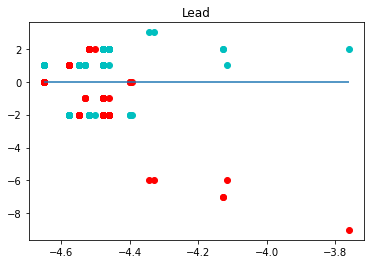

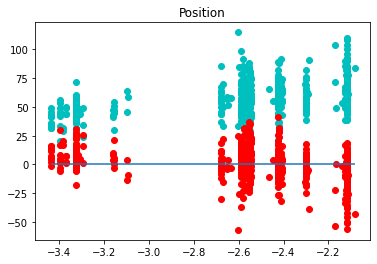

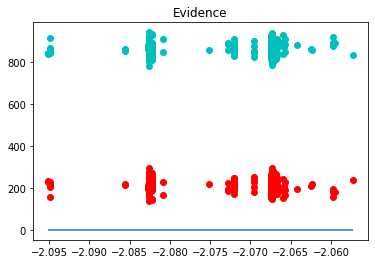

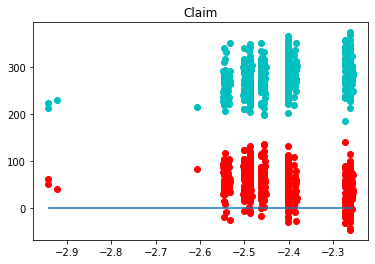

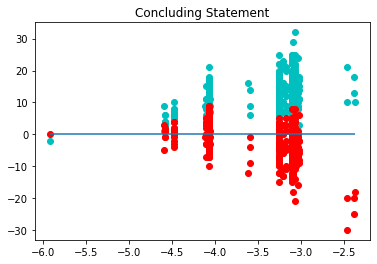

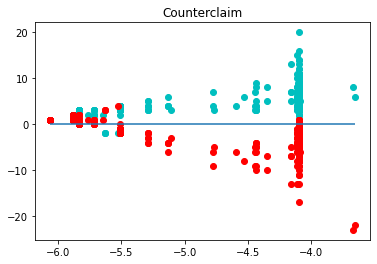

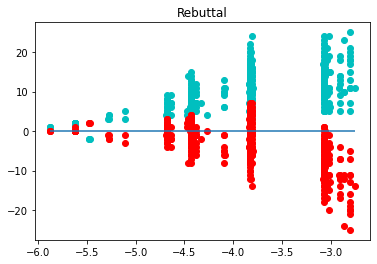

In [198]:
match_scores = {x: [] for x in range(1, 8)}
mismatch_scores = {x: [] for x in range(1, 8)}
for c in range (1, 8):
    for sample_ix, sample_id in enumerate(all_mismatched_ps):
        for span in all_mismatched_ps[sample_id][c]:
            s, e = span
            mismatch_scores[c].append((all_outs[sample_ix][s, c * 2 - 1] + all_outs[sample_ix][s + 1: e + 1, c * 2].sum())/(e - s + 1))
        for span in all_matched_ps[sample_id][c]:
            s, e = span
            match_scores[c].append((all_outs[sample_ix][s, c * 2 - 1] + all_outs[sample_ix][s + 1: e + 1, c * 2].sum())/(e - s + 1))
    
for c in range(1, 8):
    c_scores = np.array(mismatch_scores[c] + match_scores[c])
    c_labels = np.array([0] * len(mismatch_scores[c]) + [1] * len(match_scores[c]))
    thresholds = None
    samples = []
    for r in range(100):
        c_scores, c_labels = shuffle(c_scores, c_labels)
        
        score_folds = [c_scores[x::5] for x in range(5)]
        label_folds = [c_labels[x::5] for x in range(5)]
        
        train_score_datasets = [np.concatenate([score_folds[f] for f in range(5) if f != val_fold]) for val_fold in range(5)]
        train_label_datasets = [np.concatenate([label_folds[f] for f in range(5) if f != val_fold]) for val_fold in range(5)]
        val_score_datasets = score_folds
        val_label_datasets = label_folds
        
        for f in range(5):
            f_scores, f_labels = sort_(train_score_datasets[f], train_label_datasets[f])
            th = find_threshold(f_scores, f_labels)
            train_filtered = f_scores < th
            val_filtered = score_folds[f] < th
            
            samples.append((th,
                            (1 - label_folds[f][val_filtered]).sum() - (label_folds[f][val_filtered].sum() * 2) , 
                            (1 - f_labels[train_filtered]).sum() - (f_labels[train_filtered].sum() * 2) ))
    
    plt.figure()
    ths = [x[0] for x in samples]
    vals = [x[1] for x in samples]
    trains = [x[2] for x in samples]
    plt.scatter(ths, trains, c='c')
    plt.scatter(ths, vals, c='r')
    plt.hlines(0, min(ths), max(ths))
    plt.title(label_names[c])
    

In [24]:
from glob import glob

In [ ]:
for cat in range(1, 8):
    print(cat, len([x for k in all_mismatched_ps for x in all_mismatched_ps[k][cat]]),
                len([x for k in all_matched_ps for x in all_matched_ps[k][cat]]),)

1 877 7871
2 4587 11086
3 12616 33920
4 20309 33380
5 1371 11783
6 1608 3528
7 1494 2330


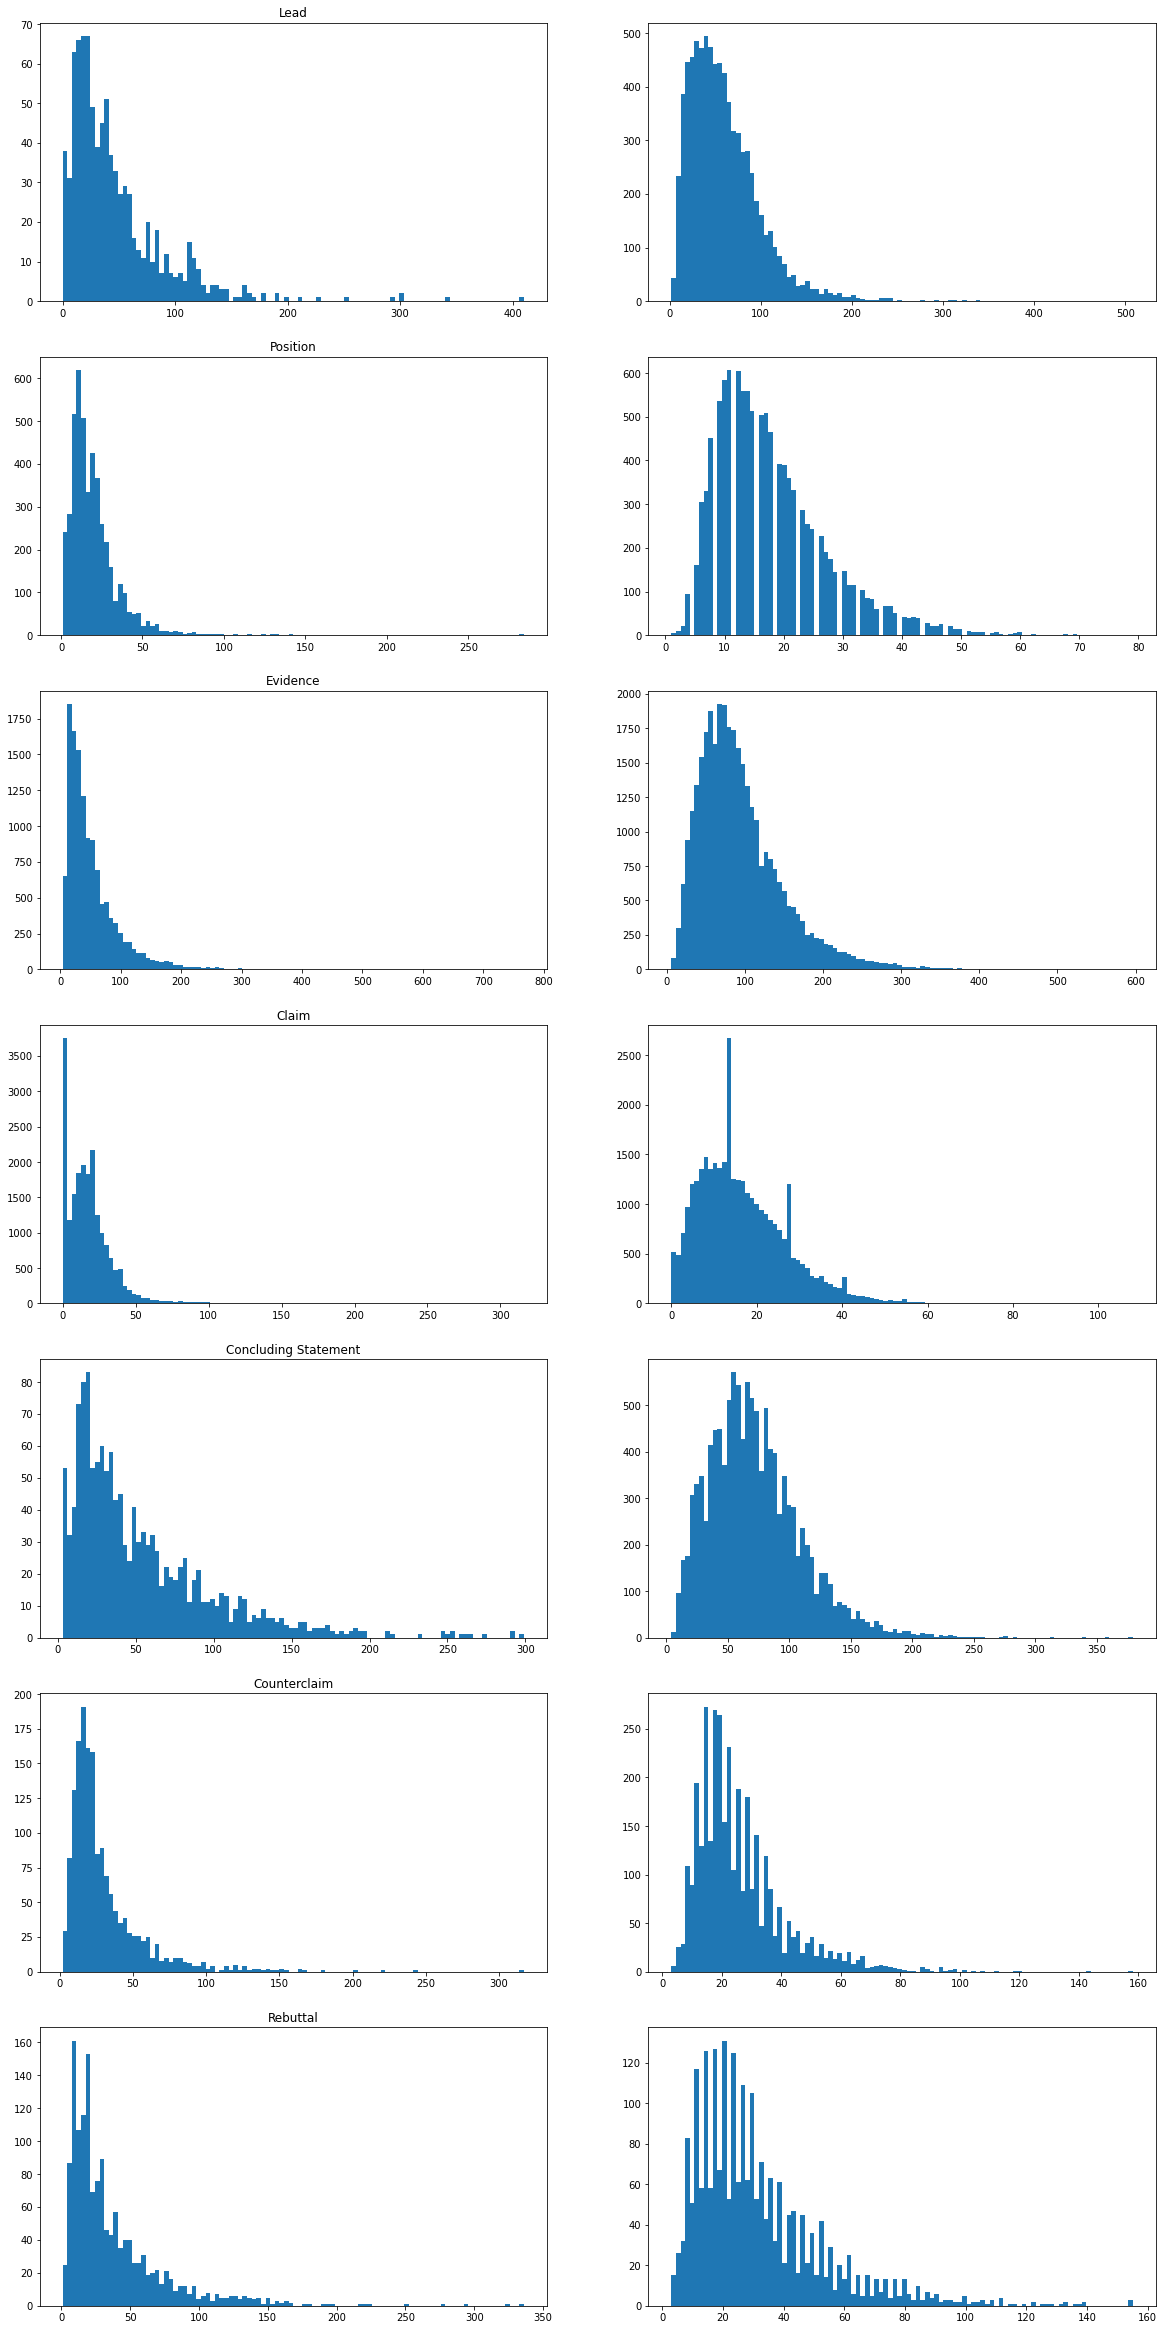

In [27]:
fig, axs = plt.subplots(7, 2, figsize=(20, 6 * 7))
for cat in range(1, 8):
    axs[cat-1, 0].set_title(label_names[cat])
    axs[cat - 1, 0].hist([x[1] - x[0] for k in all_mismatched_ps for x in all_mismatched_ps[k][cat]], 100)
    axs[cat - 1, 1].hist([x[1] - x[0] for k in all_mismatched_ps for x in all_matched_ps[k][cat]], 100)


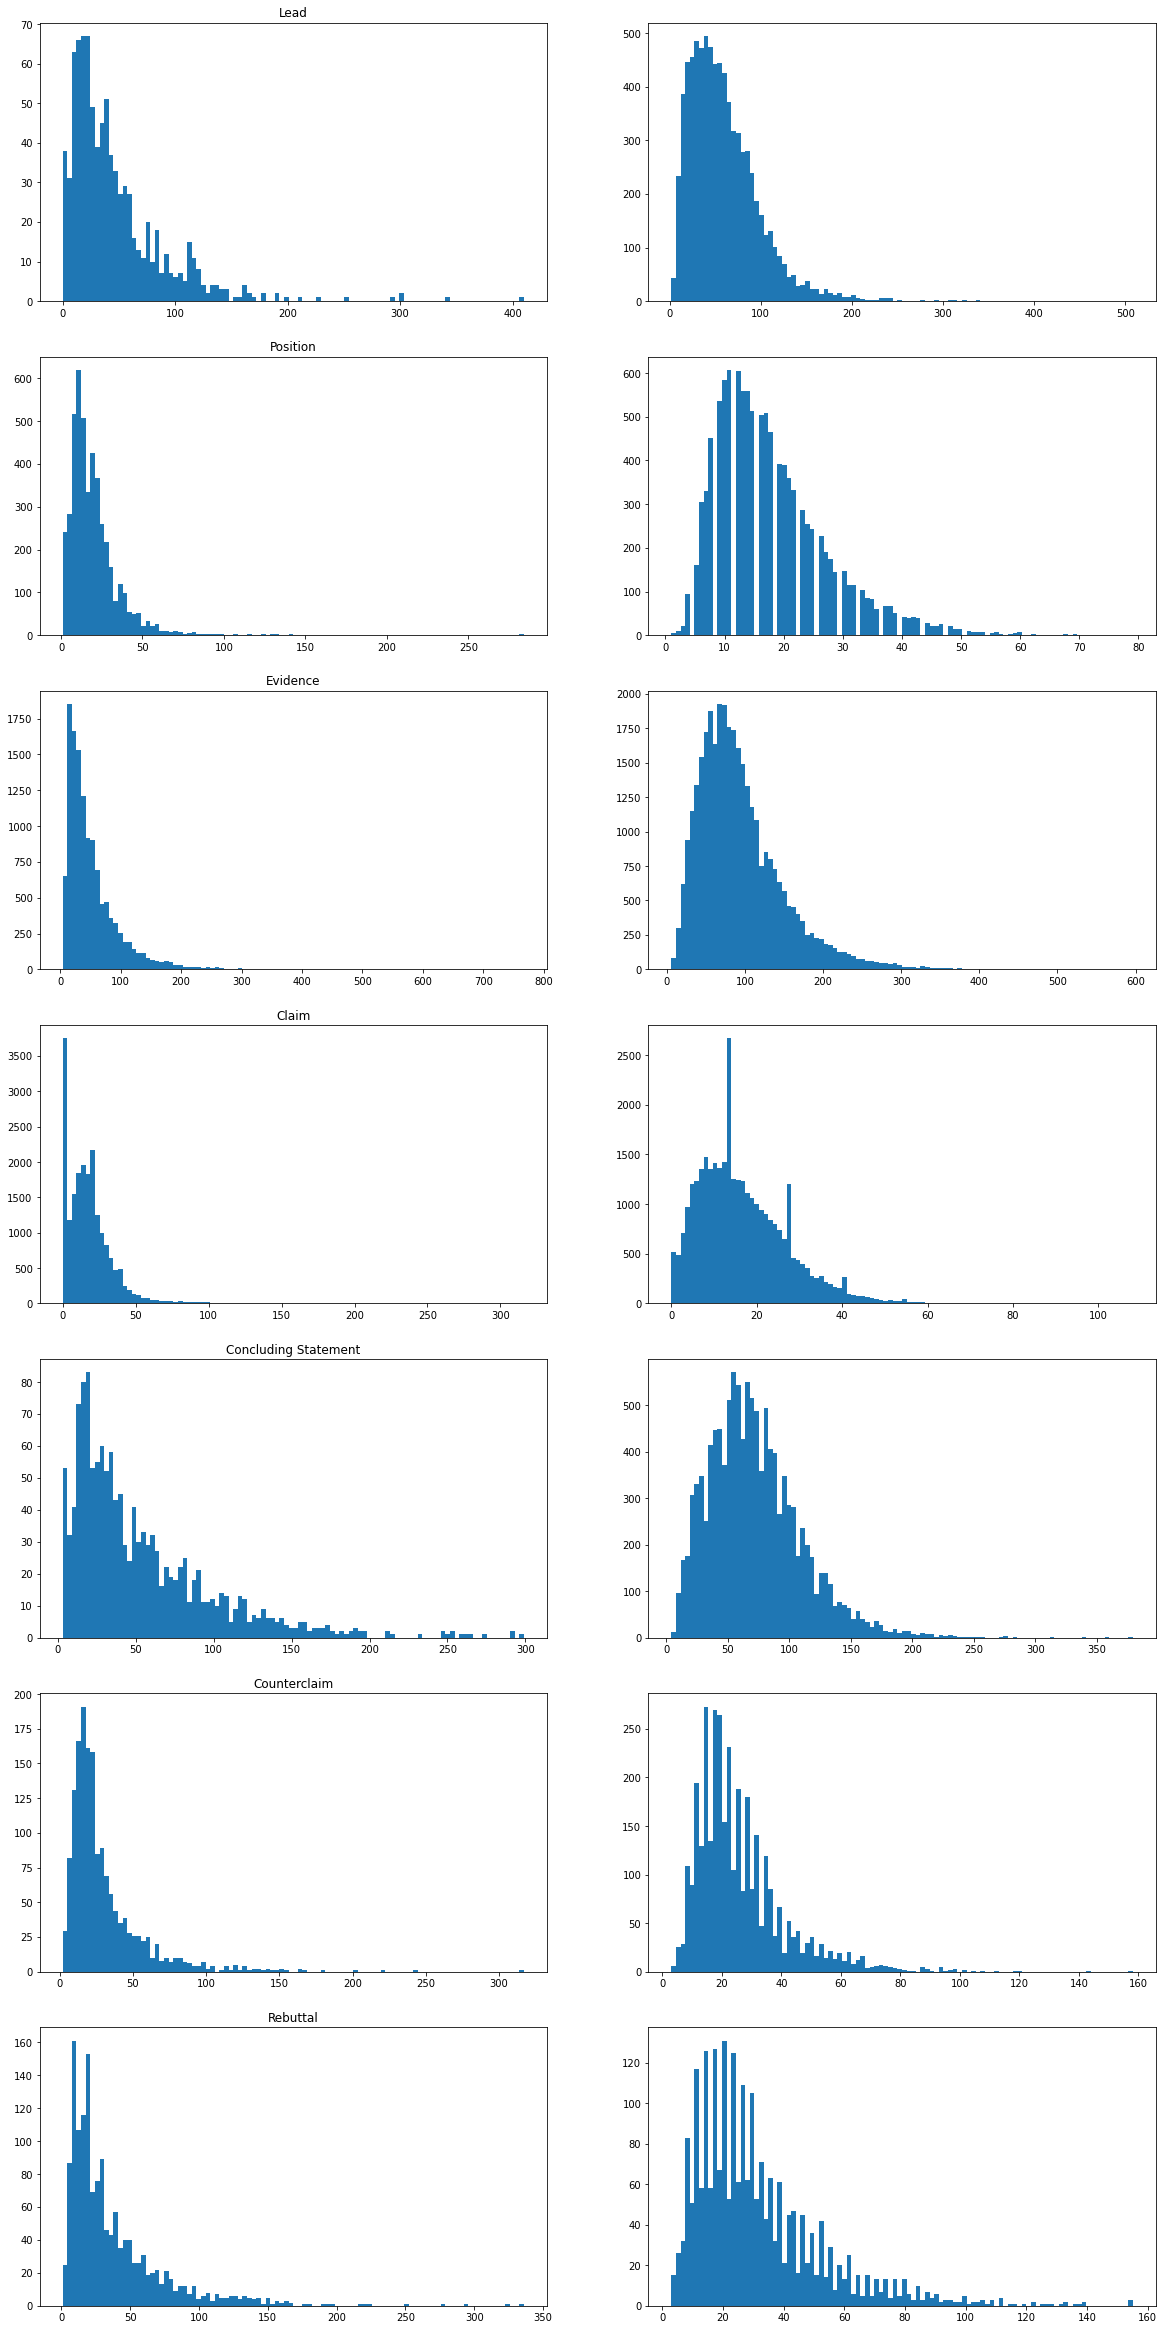

In [27]:
fig, axs = plt.subplots(7, 2, figsize=(20, 6 * 7))
for cat in range(1, 8):
    axs[cat-1, 0].set_title(label_names[cat])
    axs[cat - 1, 0].hist([x[1] - x[0] for k in all_mismatched_ps for x in all_mismatched_ps[k][cat]], 100)
    axs[cat - 1, 1].hist([x[1] - x[0] for k in all_mismatched_ps for x in all_matched_ps[k][cat]], 100)
